Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StanModels
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_s("..", "scripts", "13")
cd(ProjDir)

### snippet 13.1

In [3]:
wd = CSV.read(rel_path("..", "data", "UCBadmit.csv"), delim=';');
df = convert(DataFrame, wd);

Preprocess data

In [4]:
df[:admit] = convert(Vector{Int}, df[:admit])
df[:applications] = convert(Vector{Int}, df[:applications])
df[:male] = [(df[:gender][i] == "male" ? 1 : 0) for i in 1:size(df, 1)];
df[:dept_id] = [Int(df[:dept][i][1])-64 for i in 1:size(df, 1)];
first(df, 5)

m13_2 = "
  data{
      int N;
      int N_depts;
      int applications[N];
      int admit[N];
      real male[N];
      int dept_id[N];
  }
  parameters{
      vector[N_depts] a_dept;
      real a;
      real bm;
      real<lower=0> sigma_dept;
  }
  model{
      vector[N] p;
      sigma_dept ~ cauchy( 0 , 2 );
      bm ~ normal( 0 , 1 );
      a ~ normal( 0 , 10 );
      a_dept ~ normal( a , sigma_dept );
      for ( i in 1:N ) {
          p[i] = a_dept[dept_id[i]] + bm * male[i];
          p[i] = inv_logit(p[i]);
      }
      admit ~ binomial( applications , p );
  }
";

Define the Stanmodel and set the output format to :mcmcchain.

In [5]:
stanmodel = Stanmodel(name="m13_2", model=m13_2,
monitors=["a", "bm", "sigma_dept", "a_dept.1", "a_dept.2", "a_dept.3",
"a_dept.4", "a_dept.5", "a_dept.6"],
output_format=:mcmcchain);


File /Users/rob/.julia/dev/StanModels/scripts/13/tmp/m13_2.stan will be updated.



Input data for cmdstan

In [6]:
ucdata = Dict("N" => size(df, 1), "N_depts" => maximum(df[:dept_id]), "admit" => df[:admit],
"applications" => df[:applications],  "dept_id"=> df[:dept_id], "male" => df[:male]);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, ucdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean          SD       Naive SE       MCSE      ESS
  a_dept.1  0.673165201 0.099411354 0.0015718315 0.0021248479 1000
  a_dept.2  0.628897599 0.117492569 0.0018577206 0.0024146474 1000
  a_dept.3 -0.582930207 0.075336668 0.0011911773 0.0011508633 1000
  a_dept.4 -0.618295396 0.086214533 0.0013631715 0.0017884366 1000
  a_dept.5 -1.059692824 0.096493433 0.0015256951 0.0015833439 1000
  a_dept.6 -2.606658715 0.155039539 0.0024513903 0.0025366055 1000
         a -0.612071034 0.682236632 0.0107871083 0.0159243215 1000
        bm -0.094393102 0.081568274 0.0012897076 0.0019588067 1000
sigma_dept  1.496803429 0.601059549 0.0095035859 0.0135683661 1000

Quantiles:
               2.5%       25.0%      50.0%       75.0%       97.5%   
  a_dept.1  0.48172090  0.6044785  0.6728045  0.741389250  0.87148755
  a_dept.2  0.40201755  0.5474443  0.6307405  0.709582750  0.8

Plot the density of posterior draws

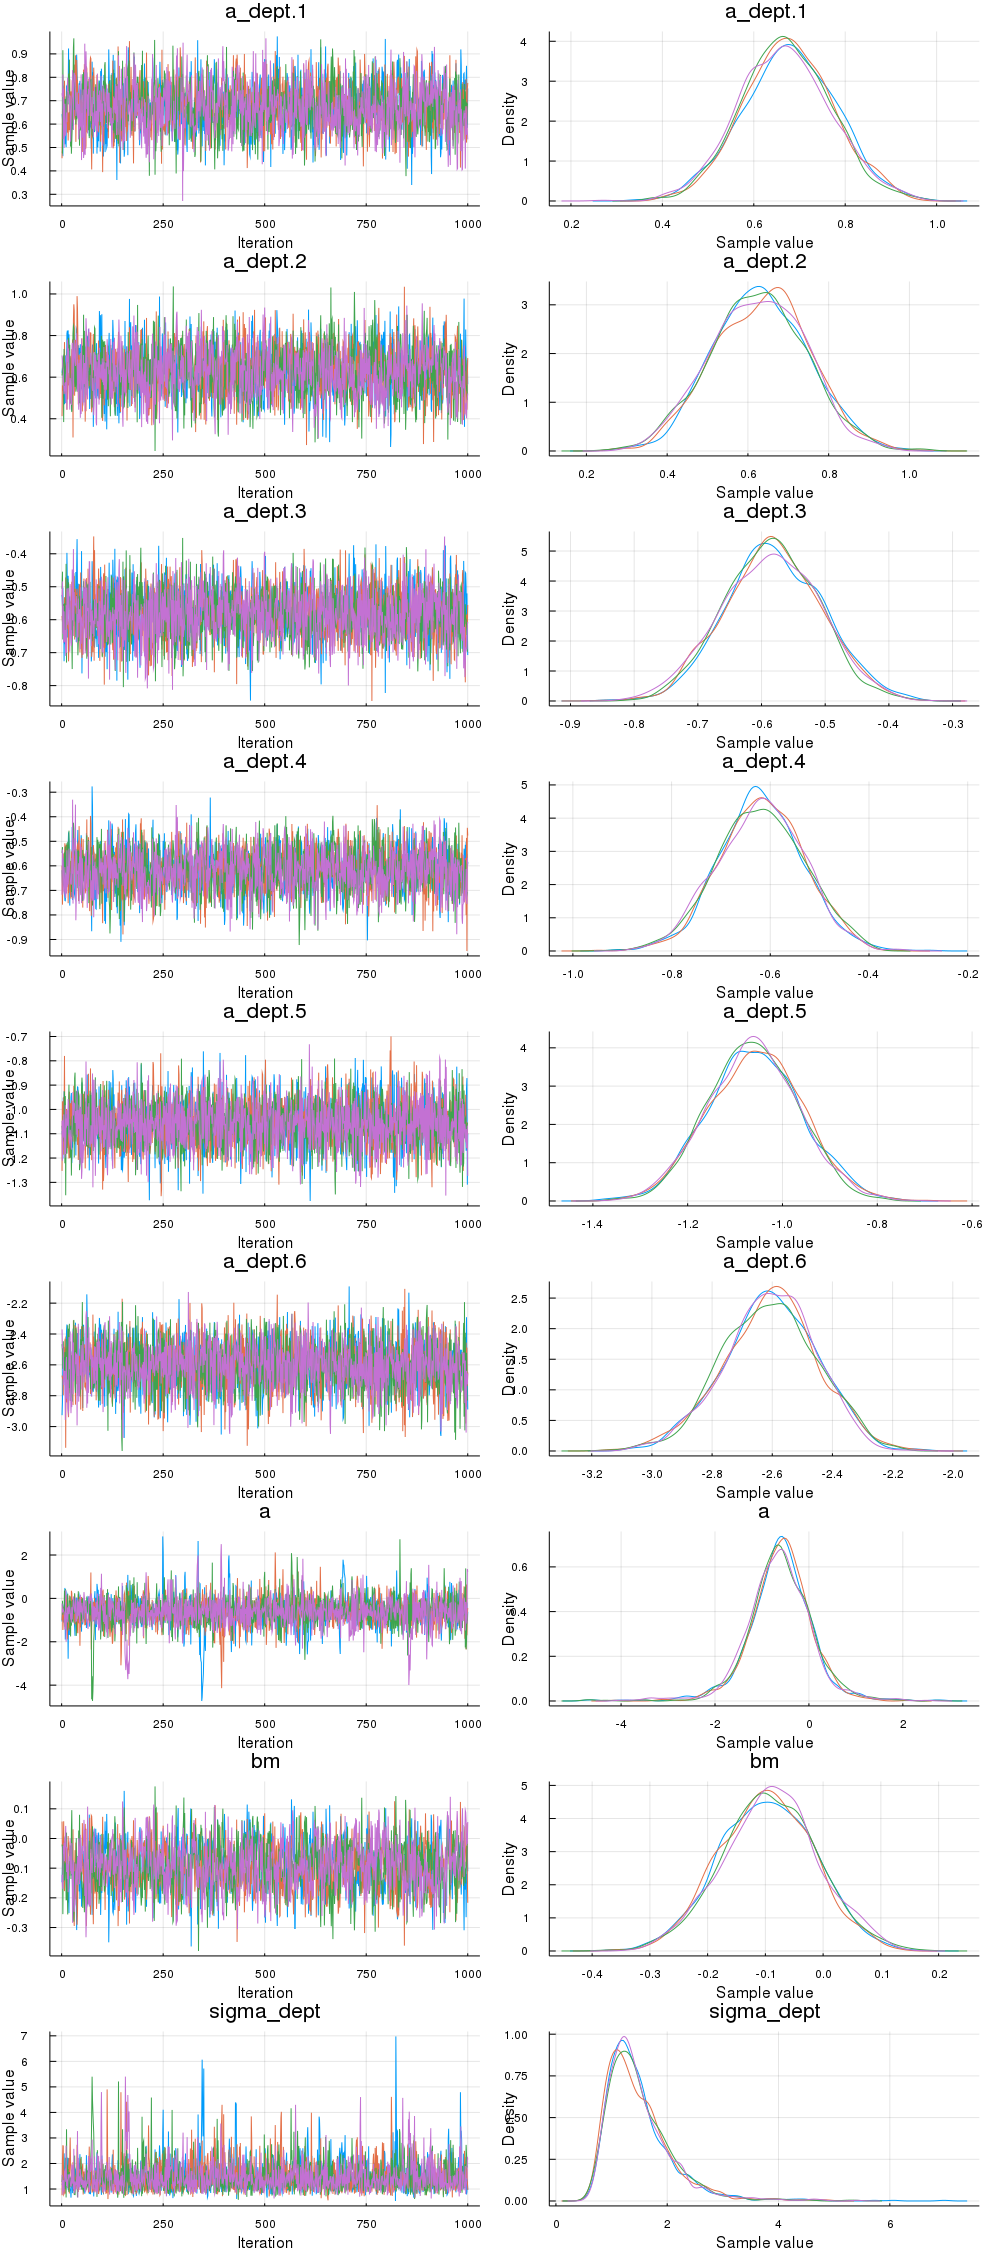

In [8]:
plot(chn)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*